['21-10-15_Tube_011_Live.fcs']
(296958, 20)
True
['APC-A', 'Alexa Fluor 700-A', 'AmCyan-A', 'BV605-A', 'BV711-A', 'BV786-A', 'PE-A', 'PE-Cy5-A', 'PE-Cy7-A', 'Pacific Blue-A', 'PerCP-Cy5-5-A']
['CD161', 'Ly-6G', 'AmCyan-A', 'CD11b', 'CD64', 'FcERI', 'CD3', 'CD19', 'CD11c', 'CD49b', 'MHCII']
(296958, 11)
Training...
 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 0.007106240616295039
 topographic error: 0.007317533119161632

...ready!
At k = 10, aka. iteration = 0
	At resampling h = 0, (k = 10)
	At resampling h = 1, (k = 10)
	At resampling h = 2, (k = 10)
17509 2 samples done... status=97.66% 


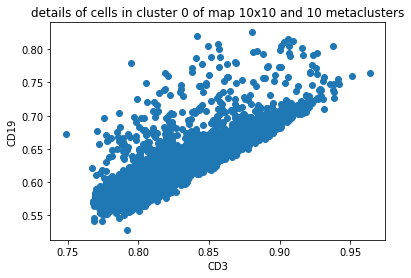

In [1]:
#!/usr/bin/python3.2
#-*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import flowio
import flowutils
import matplotlib.pyplot as plt 
from LoadFcs import *
from cluster import *
from minisom import MiniSom
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.metrics import euclidean_distances
from os import listdir
from os.path import isfile, join
from matplotlib.gridspec import GridSpec
import networkx as nx
from collections import Counter
import matplotlib.cm as cm
import sys

class _Flowsom():
    def __init__(self, data, channels=[], if_csv=False, if_drop=True, drop_col=[]):
        if if_csv:
            df = pd.read_csv(data)
        else:
            data = data[:, channels]
            df = pd.DataFrame(data, columns = channels) 

        if if_drop:
            if set(drop_col).issubset(df.columns):  
                df = df.drop(drop_col, axis =1)
        self.data = df    
       
    def som_mapping(self, x_n, y_n, d, sigma, lr, batch_size, 
                    neighborhood='gaussian',
                    seed=10):                  
        """
            Perform SOM on transform data

            Parameters
            ----------
            x_n : int
                the dimension of expected map
            y_n : int
                the dimension of expected map
            d : int
                vector length of input df
            sigma : float
                the standard deviation of initialized weights
            lr : float 
                learning rate
            batch_size : int
                        iteration times
            neighborhood : string
                        e.g. 'gaussian', the initialized weights' distribution 
            seed : int
                for reproducing
        """   
        som = MiniSom(x_n, y_n, d, sigma, lr, neighborhood_function=neighborhood, random_seed=seed) # initialize the map
        
        #df to list numpy : data.values.tolist()
        #df to array numpy : data.values
        som.pca_weights_init(self.data.values) # initialize the weights
        print("Training...")
        som.train_batch(self.data.values, batch_size, verbose=True)  # random training
        print("\n...ready!")

        self.x_n = x_n
        self.y_n = y_n
        self.weights = som.get_weights()
        self.flatten_weights = self.weights.reshape(x_n*y_n, d)
        self.map_som = som  

    def meta_clustering(self, cluster_class, min_n, max_n, iter_n, 
                        resample_proportion=0.7,verbose=False):
        """
        Perform meta clustering on SOM

        Parameters
        ----------
        cluster_class : class
                        e.g. KMeans, a cluster class, like "from sklearn.cluster import KMeans"
        min_n : int
                the min proposed number of cluster
        max_n : int
                the max proposed number of cluster
        iter_n : int
                 the iteration times for each number of clusters
        resample_proportion : float
                              within (0, 1), the proportion of re-sampling when computing clustering
        verbose : bool
                  whether print out the clustering process
        """
        
        # initialize cluster
        cluster_ = ConsensusCluster(cluster_class, 
                                    min_n, max_n, iter_n, 
                                    resample_proportion=resample_proportion)
        cluster_.fit(self.flatten_weights, verbose) # fitting SOM weights into clustering algorithm

        self.cluster_map = cluster_
        self.bestk = cluster_.bestK # the best number of clusters in range(min_n, max_n)

        # get the prediction of each weight vector on meta clusters (on bestK)
        self.flatten_class = cluster_.predict_data(self.flatten_weights)
        self.map_class = self.flatten_class.reshape(self.x_n, self.y_n) 
        self.nb_metaclusters = min_n
        
    def vis(self, with_labels, node_size, edge_color):
        """
        Visualize the meta cluster result with minimal spanning tree

        Parameters
        ----------
        with_labels : bool
                      whether the node will be visualized with its cluster label
        node_size : int
        edge_color : string
                     e.g 'b', the color of edges
        """
                
        # generate n clusters (n = bestK * t)
        #self.cluster_map.bestK = self.bestk * t
        self.cluster_map.bestK = self.x_n * self.y_n 
        self.over_class = self.cluster_map.predict_data(self.flatten_weights)
        centroid_list = []

        # Compute the centroid for each clusters
        for i in np.unique(self.over_class):
            centroid = np.mean( self.flatten_weights[self.over_class == i], axis=0 )
            centroid_list.append(centroid)
        self.centroid_list = centroid_list

        # Generate a fully connected graph of n cluster centroids for future computation 
        # on minimal spanning tree
        # (node: centroid of cluster, weight of edge: distance between two nodes)
        G = nx.Graph()
        
        for i in range(len(centroid_list)):
            for j in range(i+1, len(centroid_list)):
                # compute the distance between two nodes
                w = np.sqrt(np.dot(centroid_list[i], centroid_list[i]) - 
                            2 * np.dot(centroid_list[i], centroid_list[j]) + 
                            np.dot(centroid_list[j], centroid_list[j]))
                w /= 1
                G.add_edge(i, j, weight=w)
        self.graph = G
        mst = nx.minimum_spanning_tree(G) # compute the minimal spanning tree graph
        self.mst = mst
        
        # generate the plot
        edges,weights = zip(*nx.get_edge_attributes(mst,'weight').items())
        print (self.bestk)
        #color_list = cm.rainbow(np.linspace(0, 1, self.bestk))
        color_list = ["r", "g", "b", "y", "c", (0,0.1,0.8), (1,0.5,0), (1,1,0.3), "m", (0.4,0.6,0), "#FFC0CB", "#614B3A", "#FFD700"]
        color_map = []
        for node in mst:
            class_id, _ = Counter(self.flatten_class[self.over_class == node]).most_common()[0]
            try:
                color_map.append(color_list[class_id])
            except:
                print ('something wrong with plotting cluster %d!' % class_id)
        nx.draw(mst, 
                with_labels= with_labels, 
                node_size = node_size,
                node_color=color_map, 
                edgelist=edges, 
                edge_color=edge_color, 
                width=weights*100, 
                edge_cmap=plt.cm.Blues)
        plt.savefig('Resultats/4_Flowsom/Mst clustering - som '+str(self.x_n)+'x'+str(self.y_n)+'.png')
        plt.draw()

    def labeling(self, verbose=True):
        """
        Make prediction for the whole dataset, add a column of 'category' with prediction. 
        """
        label_list = []
        locationSOM_w1 = []
        locationSOM_w2 = []
        max_iter = len(self.data.values)
        sample_by_pos_map = {}
        for i in range(max_iter):
            percent = 100*(i+1)/max_iter
            # print the milestone
            if verbose:
                if i % 10000 == 0:
                    #print ('%d samples done...' % i)
                    sys.stdout.write(f'\r {i:2d} samples done... status={percent:0.2f}% \r')

            xx = self.data.values[i, :] # fetch the sample data
            winner = self.map_som.winner(xx) # make prediction, prediction = the closest entry location in the SOM
            c = self.map_class[winner] # from the location info get cluster info
            label_list.append(c)
            locationSOM_w1.append(winner[0]+.5)
            locationSOM_w2.append(winner[1]+.5)
            if winner in sample_by_pos_map.keys():
                sample_by_pos_map[winner].append(xx)
            else:
                sample_by_pos_map[winner] = [xx]
        self.data['category'] = label_list
        self.locationSOM_w1 = locationSOM_w1
        self.locationSOM_w2 = locationSOM_w2
        self.sample_by_pos_map = sample_by_pos_map.copy()
        #self.tf_df['category'] = label_list
        
    def metalabeling(self, ff_brut, x_n, y_n, channels_interest, pop_mark, colum_popmark=['Markers  ', "L/D"], colum_markers='Markers  '):
        pop_mark2 = pop_mark.copy()
        #print(pop_mark)
        pop_mark2 = pop_mark2.drop(columns=colum_popmark)
        pop_mark2.dropna(axis=0, how='all')
        pop_mark2.dropna(axis=1, how='all')
        colums_m = pop_mark2.columns
        #print(colums_m)
        dictio_cell_types = {}
        for m in colums_m:
            cell_type = pop_mark[[colum_markers, m]]
            cell_type = cell_type.dropna()
            cell_type = cell_type.reset_index(drop=True)
            for i in range(len(cell_type)):
                meta_markers = cell_type.loc[i, colum_markers]
                element = cell_type.loc[i, m]
                if meta_markers in dictio_cell_types.keys():   
                    dictio_cell_types[meta_markers].update( {m : element} )
                else:
                    dictio_cell_types[meta_markers] = {m:element}
                plt.savefig('Resultats/4_Flowsom/Mst clustering - som '+str(self.x_n)+'x'+str(self.y_n)+'.png')

        dict_data_by_map = self.sample_by_pos_map
        #medianValues = [np.median(values, axis=0) for key, values in dict_data_by_map.items()]
        medianValues = []
        mediankeys = []
        for key, values in dict_data_by_map.items():
            mv = np.median(values, axis=0) 
            medianValues.append(mv)
            mediankeys.append(key)
        df_medianValues = pd.DataFrame(medianValues, columns = channels_interest)
        labels = np.repeat("Unknown", x_n*y_n, axis=0)
        #print(df_medianValues)
        for cell_type in list(dictio_cell_types):
            query = dictio_cell_types[cell_type]
            #print("query ",query)
            markers = list(dictio_cell_types[cell_type].keys())
            #print("listmarqueurs ",markers)
            channels = ff_brut.get_channels(markers)
            #print("listchannels ",channels)
            scores = []     
            for channel in channels:
                if channel in channels_interest:
                    df_data = df_medianValues[channel]
                    data = df_data.to_numpy()
                    #print("channel", channel)
                    marker = ff_brut.get_markers(channel)
                    #print("marker", marker)
                    for mark in marker :
                        if query[mark] == "high":
                            op = pow((np.amax(data) - data), 2)    
                        elif  query[mark] == "low":
                            op = pow((data - np.amin(data)), 2) 
                        else:
                            sys.exit("Only high or low marker expressions are supported at the moment")
                        scores.append(op) 
            #print(len(scores))
            if len(scores) > 0:
                # Normalize between 0 and 1 and make highest score best
                #print(len(scores))
                scores = 1 - (( scores - np.amin(scores) ) / (np.amax(scores)- np.amin(scores)))
                #print("\ntaille score Normalized", np.size(scores,0), np.size(scores,1))
                #print("Normalized")
                nodeScores = np.mean(scores, axis=0)
                nodeScores[np.isnan(nodeScores)] = 0
                cutoff = np.amax(nodeScores) *0.95
                #print("cutoff", cutoff)
                scores_cutoff = nodeScores > cutoff
                selected = np.where(scores_cutoff)
                labels[selected] = cell_type
        #print(labels)
        dict_meta_labels = {}
        for i in range(len(labels)):
            dict_meta_labels[mediankeys[i]] = labels[i]
        self.dict_meta_labels = dict_meta_labels  
        #print(labels)
        return labels
        
    def plot_map(self):
        #som_output_weights = self.map_som # SOM outputs
        som_distance_map = self.map_som.distance_map() # distance map of SOM
        #print(som_distance_map)
        plt.figure()
        plt.bone()
        plt.pcolor(som_distance_map.T) 
        #plt.pcolor(som_distance_map.T, cmap='bone_r')
        plt.colorbar()
        plt.title('fsom object with '+str(self.x_n*self.y_n)+' clusters and '+str(self.nb_metaclusters)+' metaclusters')
        plt.savefig('Resultats/4_Flowsom/Figure_1 - som '+str(self.x_n)+'x'+str(self.y_n)+'.png')
        plt.show
    
    def plot_label_on_map(self):
        target = self.data['category']
        t = np.zeros(len(target), dtype=int)
        t[target == 0] = 0
        t[target == 1] = 1
        t[target == 2] = 2
        t[target == 3] = 3
        t[target == 4] = 4
        t[target == 5] = 5
        t[target == 6] = 6
        t[target == 7] = 7
        t[target == 8] = 8
        t[target == 9] = 9
        markers = ['o', 'v', '1', '3', '8', 's', 'p', 'x', 'D', '*']
        colors = ["r", "g", "b", "y", "c", (0,0.1,0.8), (1,0.5,0), (1,1,0.3), "m", (0.4,0.6,0)]
        grid = len(markers)
        sys.stdout.write('\n')
        max_iter = len(self.data.values)
        for cnt, xx in enumerate(self.data.values):
            percent = 100*(cnt+1)/max_iter
            w = self.map_som.winner(xx) 
            plt.plot(w[0]+.5, w[1]+.5, markers[t[cnt]], markerfacecolor='None',
                markeredgecolor=colors[t[cnt]], markersize=12, markeredgewidth=2)
            if cnt % 10000 == 0:
                sys.stdout.write(f'\r {cnt:2d} plot done... status={percent:0.2f}% \r')
        plt.axis([0,grid,0,grid])
        plt.savefig('Resultats/4_Flowsom/Figure 3 Grid visualisation - som '+str(self.x_n)+'x'+str(self.y_n)+' metacluster.png')
        plt.show()

    def plot_label_on_map2(self):
        markers = ['o', 'v', '1', '3', '8', 's', 'p', 'x', 'D', '*']
        colors = ["r", "g", "b", "y", "c", (0,0.1,0.8), (1,0.5,0), (1,1,0.3), "m", (0.4,0.6,0)]
        cnt = self.data['category']
        mark = []
        col = []
        for m in cnt:
            mark.append(markers[m]) 
            col.append(colors[m])
        w1 = self.locationSOM_w1
        w2 = self.locationSOM_w2
        plt.scatter(w1, w2, s=150, c=col, marker='o')
        #plt.scatter(w1, w2, mark)
        """plt.plot(w1, w2, markers[cnt], markerfacecolor='None',
                markeredgecolor=colors[cnt], markersize=12, markeredgewidth=2)
        """
        plt.axis([0,self.x_n,0,self.y_n])
        plt.savefig("Resultats/4_Flowsom/Figure_1 - som "+self.x_n+"x"+ self.y_n+"_labelisé.png")
        plt.show()

    def plot_meta_label_on_map(self):
        som_distance_map = self.map_som.distance_map() # distance map of SOM
        plt.figure(figsize=(18.5, 10.5))
        plt.bone()
        plt.pcolor(som_distance_map.T)
        plt.colorbar()
        plt.title('fsom object '+str(self.x_n*self.y_n)+' clusters and '+str(self.nb_metaclusters)+' metaclusters')
        dictio = self.dict_meta_labels
        colors = ["r", "g", "b", "y", "c", (0,0.1,0.8), (1,0.5,0), (1,1,0.3), "m", (0.4,0.6,0)]
        for w, meta_cell in dictio.items():
            samples = self.sample_by_pos_map[w]
            nb_sa = len(samples)
            winner = self.map_som.winner(samples[0]) # make prediction, prediction = the closest entry location in the SOM
            c = self.map_class[winner] # from the location info get cluster info
            plt.text(w[0]+.2, w[1]+.2, meta_cell, color=colors[c], fontsize=10)
            plt.text(w[0]+.5, w[1]+.7, nb_sa, color=colors[c], fontsize=12)
        cnt = self.data['category']
        col = []
        for m in cnt:
            col.append(colors[m])
        w1 = self.locationSOM_w1
        w2 = self.locationSOM_w2
        plt.scatter(w1, w2, s=200, c=col, marker='o')
        plt.axis([0,self.x_n,0,self.y_n])
        plt.savefig('Resultats/4_Flowsom/Figure 3 Grid visualisation - som '+str(self.x_n)+'x'+str(self.y_n)+' metacluster.png')
        plt.show()     

    def plot_details_clusters(self, ff_brut, num_cluster, channels_interest, markers):
        
        position_map = sorted(list(self.sample_by_pos_map.keys()))
        #print("sorted ", position_map)

        #print("premiere", position_map[num_cluster])
        samples = self.sample_by_pos_map[position_map[num_cluster]]
        #print(np.size(samples,0), np.size(samples,1))
        df_sample = pd.DataFrame(samples, columns = channels_interest) 
        samples = df_sample.to_numpy()
        #print(df_sample)
        df_sample_select = pd.DataFrame(df_sample, columns = ff_brut.get_channels(markers))
        #print(df_sample_select2)
        samples_select = df_sample_select.to_numpy()
        print(np.size(samples_select,0), np.size(samples_select,1))
        plt.xlabel(markers[0])
        plt.ylabel(markers[1])
        plt.scatter(samples_select[:, 0], samples_select[:, 1])
        plt.title('details of cells in cluster '+str(num_cluster)+' of map '+str(self.x_n)+'x'+str(self.y_n)+' and '+str(self.nb_metaclusters)+' metaclusters')
        plt.savefig('Resultats/4_Flowsom/Figure5 - scatter - details of cells in cluster '+str(num_cluster)+' of map '+str(self.x_n)+'x'+str(self.y_n)+'.png')
        plt.show()
        sampleEmb = TSNE(n_components=2).fit_transform(samples)
        df_sampleEmb = pd.DataFrame(sampleEmb, columns = ['tsne1', 'tsne2'])

        samples_export = self.sample_by_pos_map[position_map[num_cluster]]
        #print(np.size(samples,0), np.size(samples,1))
        df_sample_export = pd.DataFrame(samples_export, columns = ff_brut.get_markers(channels_interest))

        df_result = pd.concat([df_sampleEmb, df_sample_export], axis=1, sort=False)
        df_result.to_csv('Resultats/4_Flowsom/4_result_Dimension_Reduction.csv', index=False)
        

def get_flowset(mypath):
        files = [f for f in listdir(mypath) if f.endswith(".fcs") and isfile(join(mypath, f))]
        files = ["21-10-15_Tube_011_Live.fcs"]
        print(files)
        #We compensate and transform all files in the flowset:
        fs = []
        t_fs = []
        for f in files:
            ff = Loadfcs(mypath+f)
            ff_comp = ff.compensate()
            tlogicle_ff = ff.transform(ff_comp, range(7,20), type_transform="logicle")
            fs.append(ff)
            t_fs.append(tlogicle_ff)
        
        ff_brut = fs[0]
        ff = t_fs[0]
        return ff_brut, ff

def exo_flowsom_R(ff_brut, ff, idx_interest, x_n, y_n, sigma=2.5, lr=0.05, nb_iteration=10, seed=1):
    channels_of_interest =  ff_brut.get_channels_by_indice(idx_interest)
    print(channels_of_interest)
    markers = ff_brut.get_markers(channels_of_interest)
    print(markers)
      
    fsom = _Flowsom(ff, idx_interest, if_drop=True, drop_col=['Time'])
    print(fsom.data.shape)
    d = len(fsom.data.columns)
    fsom.som_mapping(x_n, # x_n: e.g. 100, the dimension of expected map
               y_n, # y_n: e.g. 100, the dimension of expected map
               d, # d: e.g. 19, vector length of input df
               sigma, # sigma: e.g 2.5, the sigma of initialized weights
               lr, # lr: e.g 0.1, learning rate
               nb_iteration, # batch_size: 1000, iteration times
               # neighborhood='gaussian', the initialized weights' distribution
               seed = 1 #, for reproducing
              )
    return fsom
    

def main():  
    mypath = "../inst/extdata/"
    ff_brut, ff = get_flowset(mypath)
    idx_interest = [7] + list(range(9,14)) + list(range(15,20))
    #channels2 = ff_brut.get_channels(["CD3", "CD19"])
    #idx_interest = ff_brut.get_indice(channels2)
    '''mapping som x_n = 10,  y_n = 10, metacluster = 10
    #Créer un objet fsom49 avec 49 clusters au lieu de 100 et 8 métaclusters
    x_n = 7, y_n = 7, metacluster = 8
    x_n = 5, y_n = 5, metacluster = 4
    '''
    x_n = 10
    y_n = 10
    metacluster = 10
    fsom = exo_flowsom_R(ff_brut, ff, idx_interest, x_n, y_n, nb_iteration=100000)
    # Créez un objet fsom_t_b pour lequel vous utilisez uniquement les marqueurs CD3 et CD19 pour appliquer le clustering, en utilisant 25 clusters et 4 métaclusters.
    #fsom = exo_flowsom_R(ff_brut, ff, idx_interest2,x_n, y_n, nb_iteration=100000)

    #fsom.plot_map()

    fsom.meta_clustering(AgglomerativeClustering, #  cluster_class: e.g. KMeans, a cluster class, like "from sklearn.cluster import KMeans"
                   metacluster, # min_n: e.g. 10, the min proposed number of clusters
                   metacluster+1, # max_n: e.g. 31, the max proposed number of clusters
                   3, # iter_n: e.g 10, the iteration times for each number of clusters
                   resample_proportion=0.6, # resample_proportion: e.g 0.6, the proportion of re-sampling when computing clustering
                   verbose=True #verbose: e.g. False, whether print out the clustering process
                  )
    fsom.labeling()
    #print(fsom.data['category'])
    """nous pouvons essayer d'identifier les populations qui nous intéressent
    Nous pouvons fournir un tableau définissant les marqueurs qui s'expriment dans les populations qui nous intéressent:
    """
    pop_mark = pd.read_excel('../inst/extdata/Populations and markers.xlsx')
    channels_interest = ff_brut.get_channels_by_indice(idx_interest)
    labels = fsom.metalabeling(ff_brut, x_n, y_n, channels_interest, pop_mark, colum_popmark=['Markers  ', "L/D"])
    #print(labels)
    #print(fsom.dict_meta_labels)

    #fsom.plot_meta_label_on_map()
    #---plot
    #fsom.plot_label_on_map()
    #fsom.plot_label_on_map2()

    fsom.plot_details_clusters(ff_brut, 0, channels_interest, ["CD3","CD19"])
    
    """
    print("bestk ", fsom.bestk, "\n")  
    fsom.vis(#t=5, # the number of total nodes = t * bestk
        edge_color='b', 
        node_size=400, 
        with_labels=True)
    """

if __name__ == '__main__':
    main()